In [ ]:
# Conclusion:
# I found the Convolutional Neural Network to be pretty dismal.  
# I'm wondering if a CNN is a good approach for predicting the next element in a series.  
# Perhaps there is a better model for problems like this.  

In [7]:
# ---------------Load Data-----------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as random
import os as os
%matplotlib inline 

# data = pd.read_csv('data/training.csv')
print('libraries imported!')


libraries imported!


# Def getting stock data (getting next batch)

In [68]:
stockFiles = os.listdir('stockData')
predictionsCount = 1 #the High, Low, and close over the course of the prediction period
setupArrayLength = 50 # this should be the numDays you want in a setup x 5 

def getStockData(fileName, start, setupLength, predictLength):
    setupData = []
    file = open('stockData/' + fileName)
    fLines = file.readlines()
    end = start + setupLength + predictLength -1
    predictStartDate = fLines[start + predictLength -1].split(',')[0]
    predictEndDate = fLines[start].split(',')[0]
    high = 0
    low = 1000000
    
    # get the 'old' stock data
    for i in range(end, start-1, -1):
        line = fLines[i].strip()
        lineArray = line.split(',')
        for k in range(1,7):
            lineArray[k] = float(lineArray[k])
        x = lineArray[6]/lineArray[4]

        if(i>=(start+predictLength)):
            for j in range(1,5):
                setupData.append(lineArray[j]*x)
            setupData.append(lineArray[5])

    
    # get the high/low of 'new' stock data (we try and predict this)
        if(i<(start + predictLength)):
            if (lineArray[2]*x > high):
                high = lineArray[2]*x
            if (lineArray[3]*x < low):
                low = lineArray[3]*x
                
        close = float(fLines[start].split(',')[4])*x
    
    file.close()
    
    
    # ----------------------convert data to 0=>1 instead of prices
    tmpHi = 0
    tmpLow = 1000000
    tmpVolHi = 0
    tmpVolLow = 1000000000
    
    for i in range(0,len(setupData)): # find the His and Lows for vol and price
        if(5*(i//5)+1 == i):
            if(setupData[i] > tmpHi):
                tmpHi = setupData[i]
        if(5*(i//5)+2 == i):
            if(setupData[i] < tmpLow):
                tmpLow = setupData[i]
        if(5*(i//5)+4 == i):
            if(setupData[i] > tmpVolHi):
                tmpVolHi = setupData[i]
            if(setupData[i] < tmpVolLow):
                tmpVolLow = setupData[i]
    
    if(tmpHi-tmpLow ==0): #special case where the tmpHi and tmpLow are equal to eachother
            tmpLow = tmpLow - .10
    if(tmpVolHi-tmpVolLow ==0): 
        tmpVolLow = tmpVolLow - .10

    for i in range(0,len(setupData)): # convert the data to values between 0 and 1
        if(5*(i//5)+4 != i):
            setupData[i] = (setupData[i] - tmpLow)/(tmpHi-tmpLow)
        if(5*(i//5)+4 == i):
            setupData[i] = (setupData[i] - tmpVolLow)/(tmpVolHi-tmpVolLow)
        
    futureLabels = [(close-tmpLow)/(tmpHi-tmpLow)]
    symbolAndPredictDates = [fileName.split('.')[0], predictStartDate, predictEndDate]
            
    return setupData, futureLabels, symbolAndPredictDates
 


def getBatch(setupLength, predictLength):
    randIndex = random.randint(0,950)
    fileName = stockFiles[randIndex]
    file = open('stockData/' + fileName)
    fLines = file.readlines()
    file.close()
    start = random.randint(1, (len(fLines) - setupLength - predictLength - 1))
    spySetupData, spyLabels, labelDates = getStockData('SPY.txt',start,setupLength,predictLength)
    stockSetupData, stockLabels, labelDates = getStockData(fileName,start,setupLength,predictLength)
    setupData = []
    futureLabels = []
    
    setupData.append(stockSetupData)
    setupData.append(spySetupData)
    futureLabels.append(stockLabels)
    
    return np.asarray(setupData,dtype=np.float32), np.asarray(futureLabels,dtype=np.float32), labelDates
    


print('get Data methods defined')

greg,j,k = getBatch(10,1)
print(j)
# print(greg)

get Data methods defined
[[ 0.77419233]]


# Set up our CNN methods

In [45]:
# set up our weights (or kernals?) and biases for each pixel
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(.1, shape=shape, dtype=tf.float32)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, [1,1,1,1], 'SAME')

# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')



# placeholder variables
# stock_setupData
x = tf.placeholder(tf.float32, shape=[None, setupArrayLength])

# stockPredictionData
y_ = tf.placeholder(tf.float32, shape=[None, predictionsCount])



print('methods defined')

methods defined


# set up our CNN

In [46]:
# ----------------first convolutional layer---------------------------
W_conv1 = weight_variable([1, 5, 1, 32]) # filterHeight,filterWidth,inChannels,outFeatures
b_conv1 = bias_variable([32])

# x,l = (getStockData('AXS.txt', 2,1))

# turn shape(stockDaysCount,5)  into   (?,stockDaysCount,5,1) ... so it will work with the conv2d method
stockDaysCount = int(setupArrayLength/5)
stock = tf.reshape(x, [-1,stockDaysCount,5,1])  # numStocks,stockDaysCount,width,numChannels
# print (stock.get_shape()) # =>(?,stockDaysCount,5,1)

h_conv1 = tf.nn.relu(conv2d(stock, W_conv1) + b_conv1)
# print (h_conv1.get_shape()) # => (?, stockDaysCount, 5, 32)


# ------------------------------not really sure we need max pooling?  there aren't that many data points
# h_pool1 = max_pool_2x2(h_conv1)
# print (h_pool1.get_shape()) # => (?, 48, 48, 32)




#-------------------------- second convolutional layer-----------------
W_conv2 = weight_variable([1, 5, 32, 64]) # filterHeight,filterWidth,inChannels,outFeatures
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
# print (h_conv2.get_shape()) # => (?, stockDaysCount,5,64)

#------------------again----------------no pooling
# h_pool2 = max_pool_2x2(h_conv2)
# print (h_pool2.get_shape()) # => (?, 24, 24, 64)



#-------------------------fully connected layer-----------------------
W_fc1 = weight_variable([stockDaysCount * 5 * 64, 1024])
b_fc1 = bias_variable([1024])

# (?, 24, 24, 64) => (?, 36864)
h_conv2_flat = tf.reshape(h_conv2, [-1, stockDaysCount*5*64])
# print h_pool2_flat.get_shape() = (?, 36864)

h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)
# print (h_fc1.get_shape()) # => (?, 1024)



# ---------------------------------readout layer-------------------------------
W_fc2 = weight_variable([1024, predictionsCount])
b_fc2 = bias_variable([predictionsCount])

readout_layer = (tf.matmul(h_fc1, W_fc2) + b_fc2)
# print (readout_layer.get_shape()) #=> (?, 1)



print('Convolutional Nueral Net Defined')

Convolutional Nueral Net Defined


# define training step and train

In [63]:
print(readout_layer.get_shape())
prediction_delta = tf.reduce_sum(tf.abs((readout_layer - y_)))
train_step = tf.train.AdamOptimizer(1e-04).minimize(prediction_delta)
# train_step = tf.train.GradientDescentOptimizer(.5).minimize(prediction_delta)


sess = tf.Session()
sess.run(tf.initialize_all_variables())
# xx, yy, zz = getBatch(50,10)
   

predictions = []
actuals = []
for i in range(0,5001):
    xx, yy, zz = getBatch(10,1)
    actuals.append(yy[0])
    predicion = sess.run(tf.reduce_mean(readout_layer), feed_dict={x:xx, y_:yy})
    predictions.append(predicion)
    sess.run(train_step, feed_dict={x: xx, y_: yy})
    if(i%100 == 0):
        print(zz[0] + ' prediction_delta ' + str(i+1) + 
              ': ' + str(sess.run(prediction_delta, feed_dict={x: xx, y_: yy})))


(?, 1)
MTDR prediction_delta 1: 2.81692
TEVA prediction_delta 101: 1.90998
C prediction_delta 201: 0.445477
GLPI prediction_delta 301: 1.13038
WB prediction_delta 401: 0.125559
ETP prediction_delta 501: 0.722036
ARE prediction_delta 601: 0.148678
EZU prediction_delta 701: 2.04189
BID prediction_delta 801: 1.52726
WM prediction_delta 901: 0.470991
CDE prediction_delta 1001: 0.630739
PDCE prediction_delta 1101: 0.775513
NEM prediction_delta 1201: 0.862133
KATE prediction_delta 1301: 0.22212
REG prediction_delta 1401: 0.388048
AER prediction_delta 1501: 0.281486
PCAR prediction_delta 1601: 1.23284
WWW prediction_delta 1701: 0.173415
TRMB prediction_delta 1801: 0.605353
KIM prediction_delta 1901: 0.356824
IMS prediction_delta 2001: 0.340116
UFS prediction_delta 2101: 1.25081
ATU prediction_delta 2201: 0.694122
VOO prediction_delta 2301: 0.447544
SH prediction_delta 2401: 1.12905
KNX prediction_delta 2501: 0.461177
BABA prediction_delta 2601: 0.38831
HOG prediction_delta 2701: 1.58269
GWPH 

ZeroDivisionError: float division by zero

-0.211534
average prediction delta: 0.35


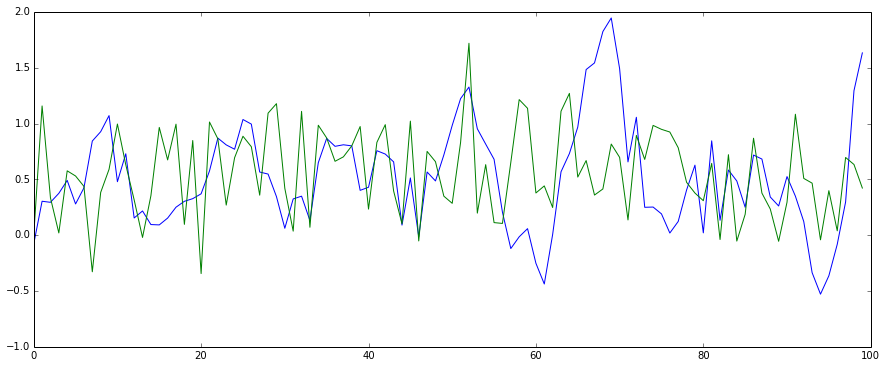

In [67]:
print(predictions[40])
deltas = []
for i in range(len(predictions)):
    deltas.append(abs(predictions[i]-actuals[i]))

print('average prediction delta: {:.2f}'.format(np.mean(deltas)))

plt.rcParams['figure.figsize'] = (15,6)
plt.plot(predictions[600:700]) #blue
plt.plot(actuals[600:700]) #green

In [ ]:
class greg:
    def getCups(self):
        return 'cccups'
    
    def __init__(self,x,y):
        print(x + ' ' + y)
        arr = [1,2,3,4,5,6]
        self.cups = self.getCups()
        self.last = arr[-1]
        
lilGreg = greg('yup','hey')
print(lilGreg.cups)
print(lilGreg.last)


for i in range(0,10,2):
    print('greg')